In [25]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem.Draw import rdMolDraw2D

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from math import sqrt

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
import kerastuner as kt

from collections import Counter 
import collections
import seaborn as sns
import re

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import Concatenate
from numpy.random import seed
import tensorflow

In [2]:
DF_polyinfo = pd.read_excel("FFV_homopolymer.xlsx")

In [6]:
DF_polyinfo 

,Unnamed: 0,Smiles,FFV
0,0,*C*,0.409672
1,1,*C(C*)CCCCCCC,0.405013
2,2,*C(C*)CCCCCCCC,0.410422
3,3,*C(C*)(CC)C,0.361221
4,4,*C(CC*)(C)C,0.396204
...,...,...,...
6584,6584,*C1C(CC(C1)C(O)(C(F)(F)F)C(F)(F)F)(C(C*)(F)F)F,0.320846
6585,6585,*c1cc2C3(CCC(CC3)(C3=NC(CO3)c3ccccc3)C3=NC(CO3...,0.405650
6586,6586,*c1cc2C3(CCC(CC3)(C3=NC(CO3)Cc3ccccc3)C3=NC(CO...,0.396617
6587,6587,*C(C*)(C(=O)OCC(Cl)(Cl)Cl)F,0.363808


In [3]:
polyamide = pd.read_excel("FFV_polyamides.xlsx")

In [4]:
polyamide 

,Unnamed: 0,RepeatUnit,FFV
0,0,*NCc1cccc(N*)c1,0.325268
1,1,*NCc1ccc(N*)cc1,0.323276
2,2,*Nc1cccc(S(=O)(=O)c2cccc(N*)c2)c1,0.334696
3,3,*Nc1ccc(-c2ccc(N*)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0.326938
4,4,*NCCCN(C)CCCN*,0.325919
...,...,...,...
1452,1452,*Nc1cc2c(cc1N*)C(C[C@H](CC)CCCC)(C[C@H](CC)CCC...,0.354414
1453,1453,*Nc1ccc([C@]2(C)CC(C)(C)c3cc(N*)ccc32)cc1,0.366439
1454,1454,*Nc1ccc([C@@]2(C)CC(C)(C)c3cc(N*)ccc32)cc1,0.367313
1455,1455,*Nc1ccc2c(c1)[C@]1(CCC)c3ccc(N*)cc3[C@]3(CCC)c...,0.393445


C:\Users\let20002\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


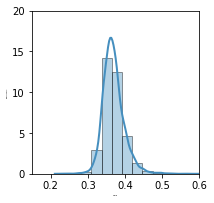

In [7]:
plt.figure(figsize=(3,3))
ax=plt.subplot(1, 1, 1)
sns.distplot(DF_polyinfo['FFV'],color=(0.27,0.56,0.75), bins=20,hist_kws=dict(edgecolor="black", linewidth=1),kde_kws={"lw": 2})
#plt.title('Seattle Weather Data', fontsize=18)
plt.xlabel('Wind', fontsize=2)
plt.ylabel('Frequency', fontsize=2)
plt.xlim([0.15, 0.6])
plt.ylim([0, 20])
ax.set_yticks([0,5,10,15,20])
plt.savefig("Homo_His.png", dpi=1200, bbox_inches='tight') 

C:\Users\let20002\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


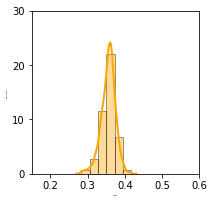

In [8]:
plt.figure(figsize=(3,3))
ax=plt.subplot(1, 1, 1)
sns.distplot(polyamide['FFV'],color="orange", bins=6,hist_kws=dict(edgecolor="black", linewidth=1),kde_kws={"lw": 2})
#plt.title('Seattle Weather Data', fontsize=18)
plt.xlabel('Wind', fontsize=2)
plt.ylabel('Frequency', fontsize=2)
plt.xlim([0.15, 0.6])
plt.ylim([0, 30])
ax.set_yticks([0,10,20,30])
plt.savefig("Polyamide_His.png", dpi=1200, bbox_inches='tight') 

In [11]:
DF_all = pd.read_csv("All.txt", sep=" ", header=None)

In [12]:
DF_all

,0
0,*C*
1,*C(C*)CCCCCCC
2,*C(C*)CCCCCCCC
3,*C(C*)(CC)C
4,*C(CC*)(C)C
...,...
8133,*Oc1cc2c(cc1O*)C1(CC2(C)C)CC(C)(C)c2cc3c(cc21)...
8134,*Oc1cc2c(cc1O*)C1(CC2(C)C)CC(C)(C)c2cc3c(cc21)...
8135,C(C(F)(F)[*])(F)(F)[*]
8136,C(C(F)(F)[*])(F)(F)[*]


In [13]:
molecules = DF_all[0].apply(Chem.MolFromSmiles)

DF_all.loc[:,['molecules']] = molecules
DF_all = DF_all.dropna()

fp = molecules.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_n = fp.apply(lambda m: m.GetNonzeroElements())

In [14]:
HashCode = []
for i in fp_n:
    for j in i.keys():
        HashCode.append(j)
        
unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [15]:
MY_finger = []
for polymer in fp_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)
    
MY_finger_dataset_1 = pd.DataFrame(MY_finger)  

In [16]:
# filter input into the most popular 133 substructures
Zero_Sum = (MY_finger_dataset_1 == 0).astype(int).sum()
NumberOfZero = 7600 
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X_dataset_1 = MY_finger_dataset_1[Zero_Sum[Zero_Sum < NumberOfZero].index]

133


In [18]:
X_dataset_1 = X_dataset_1[:8046]

In [20]:
Y = np.array(list(DF_polyinfo['FFV']) + (list(polyamide['FFV'])))

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X_dataset_1.values, Y, test_size=0.2, random_state=42)

In [26]:
A1 = Input(shape=(133),name='A1')
A2 = Dense(48, activation='relu',name='A2')(A1)
A3 = Dense(24, activation='relu',name='A3')(A2)
A4 = Dense(24, activation='relu',name='A4')(A3)
A6 = Dense(1, name='A6')(A4)

B2 = Dense(48, activation='relu',name='B2')(A1)
B3 = Dense(24, activation='relu',name='B3')(B2)
B4 = Dense(24, activation='relu',name='B4')(B3)
B6 = Dense(1, name='B6')(B4)

C2 = Dense(48, activation='relu',name='C2')(A1)
C3 = Dense(24, activation='relu',name='C3')(C2)
C4 = Dense(24, activation='relu',name='C4')(C3)
C6 = Dense(1, name='C6')(C4)

concat_layer = Concatenate()([A6, B6, C6])

model = Model(inputs=[A1],outputs=concat_layer)
model.compile(loss = "mse", optimizer = 'adam')

seed(1)
tensorflow.random.set_seed(1*7+333)

history = model.fit(X_dataset_1.values, [Y, Y, Y], epochs=100, batch_size=4, verbose=2)

Epoch 1/100
2012/2012 - 4s - loss: 0.0090
Epoch 2/100
2012/2012 - 4s - loss: 6.8125e-04
Epoch 3/100
2012/2012 - 4s - loss: 4.8496e-04
Epoch 4/100
2012/2012 - 4s - loss: 4.2496e-04
Epoch 5/100
2012/2012 - 4s - loss: 3.6259e-04
Epoch 6/100
2012/2012 - 4s - loss: 3.4045e-04
Epoch 7/100
2012/2012 - 4s - loss: 3.0953e-04
Epoch 8/100
2012/2012 - 4s - loss: 2.9960e-04
Epoch 9/100
2012/2012 - 4s - loss: 2.7824e-04
Epoch 10/100
2012/2012 - 4s - loss: 2.6077e-04
Epoch 11/100
2012/2012 - 4s - loss: 2.4689e-04
Epoch 12/100
2012/2012 - 4s - loss: 2.3522e-04
Epoch 13/100
2012/2012 - 4s - loss: 2.3966e-04
Epoch 14/100
2012/2012 - 4s - loss: 2.3028e-04
Epoch 15/100
2012/2012 - 4s - loss: 2.1110e-04
Epoch 16/100
2012/2012 - 4s - loss: 2.0553e-04
Epoch 17/100
2012/2012 - 4s - loss: 2.0767e-04
Epoch 18/100
2012/2012 - 4s - loss: 1.8818e-04
Epoch 19/100
2012/2012 - 4s - loss: 1.8804e-04
Epoch 20/100
2012/2012 - 4s - loss: 1.7679e-04
Epoch 21/100
2012/2012 - 4s - loss: 1.7317e-04
Epoch 22/100
2012/2012 - 4

In [27]:
output = Dense(1,name='out')(model.layers[-1].output)

model = Model(inputs=[A1],outputs=output)
model.compile(loss = "mse", optimizer = 'adam')

In [28]:
#https://stackoverflow.com/questions/47183159/how-to-set-weights-in-keras-with-a-numpy-array
    
l=[]
x=np.array(np.array([1/3,1/3,1/3,]).reshape(3,1)) #weights
y=np.array([0]) #array of biases
l.append(x)
l.append(y)

model.layers[-1].set_weights(l)  
model.layers[-1].get_weights()

[array([[0.33333334],
        [0.33333334],
        [0.33333334]], dtype=float32),
 array([0.], dtype=float32)]

Train set R^2:  0.9514437967715402
Train set R^2:  0.924851508540492


Text(0.5, 1.0, 'Fingerprint')

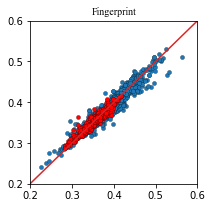

In [29]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)


y_pred_train = model.predict((X_dataset_1[:6589]))
print("Train set R^2: ", r2_score(Y[:6589], y_pred_train))
plt.scatter(Y[:6589], y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)

y_pred_train = model.predict((X_dataset_1[6589:6589 + 1457]))
print("Train set R^2: ", r2_score(Y[6589:6589 + 1457], y_pred_train))
plt.scatter(Y[6589:6589 + 1457], y_pred_train, c='red', marker='o', s = 18, edgecolors='k', linewidths = 0.2)

plt.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), '#d62728')
plt.xlim([0.2, 0.6])
plt.ylim([0.2, 0.6])
ax.set_xticks([0.2,0.3,0.4,0.5,0.6])
ax.set_yticks([0.2,0.3,0.4,0.5,0.6])
plt.title('Fingerprint',fontname="Times New Roman", fontsize=10)
#plt.savefig("FFV_parity_fingerprint.png", dpi=1200, bbox_inches='tight') 